
# Semana 7 — MLP em PyTorch 🧠🔥

Neste notebook você vai:
1) Construir um **MLP** (Multi-Layer Perceptron) com **PyTorch**.  
2) Treinar em um dataset 2D (`make_moons`) e visualizar a **fronteira de decisão**.  
3) Medir **loss** e **acurácia** (treino/teste).  
4) Entender o **loop de treino** (forward → loss → backward → step).

> Se necessário, instale o PyTorch (CPU):  
> `pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu`


In [26]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import TensorDataset, DataLoader
    TORCH_OK = True
except Exception as e:
    TORCH_OK = False
    print("⚠️ PyTorch não disponível neste ambiente.", e)


## 1) Dados e padronização

In [27]:
# Variáveis a serem ajustadas
noise = 0.25
hidden=(64,32,16)
dropout=0.2
lr=5e-4
weight_decay=1e-3
epochs=400



In [28]:

X, y = make_moons(n_samples=1200, noise=noise, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
X_train_s.shape, X_test_s.shape


((900, 2), (300, 2))

## 2) Tensores + DataLoader

In [29]:

if not TORCH_OK:
    raise SystemExit("Instale PyTorch para continuar.")

Xtr_t = torch.tensor(X_train_s, dtype=torch.float32)
ytr_t = torch.tensor(y_train,   dtype=torch.long)
Xte_t = torch.tensor(X_test_s,  dtype=torch.float32)
yte_t = torch.tensor(y_test,    dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 3) Modelo MLP

In [30]:

class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=(64,32,16), out_dim=2, dropout=0.2):
        super().__init__()
        h1, h2, h3 = hidden
        self.fc1 = nn.Linear(in_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, out_dim)
        self.do  = nn.Dropout(p=dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x)); x = self.do(x)
        x = F.relu(self.fc2(x)); x = self.do(x)
        x = self.fc3(x)
        return x

model = MLP(hidden=hidden, dropout=dropout).to(device)
model


MLP(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
  (do): Dropout(p=0.2, inplace=False)
)

## 4) Treino (loop padrão PyTorch)

In [31]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
epochs = epochs

train_losses, val_losses = [], []

for ep in range(1, epochs+1):
    model.train(); run=0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        run += loss.item() * xb.size(0)
    train_losses.append(run / len(train_loader.dataset))

    model.eval(); vrun=0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            vrun += criterion(model(xb), yb).item() * xb.size(0)
    val_losses.append(vrun / len(test_loader.dataset))

    if ep % 25 == 0 or ep == 1:
        print(f"epoch {ep:03d} | train={train_losses[-1]:.4f} | val={val_losses[-1]:.4f}")



epoch 001 | train=2.5138 | val=2.3953
epoch 025 | train=0.3175 | val=0.2856
epoch 050 | train=0.2622 | val=0.2183
epoch 075 | train=0.2382 | val=0.1856
epoch 100 | train=0.2159 | val=0.1672
epoch 125 | train=0.1985 | val=0.1579
epoch 150 | train=0.2014 | val=0.1524
epoch 175 | train=0.1956 | val=0.1544
epoch 200 | train=0.1907 | val=0.1469
epoch 225 | train=0.2022 | val=0.1498
epoch 250 | train=0.1857 | val=0.1498
epoch 275 | train=0.1937 | val=0.1467
epoch 300 | train=0.1946 | val=0.1467
epoch 325 | train=0.1990 | val=0.1456
epoch 350 | train=0.1834 | val=0.1444
epoch 375 | train=0.1740 | val=0.1428
epoch 400 | train=0.1883 | val=0.1425


## 5) Curvas de loss

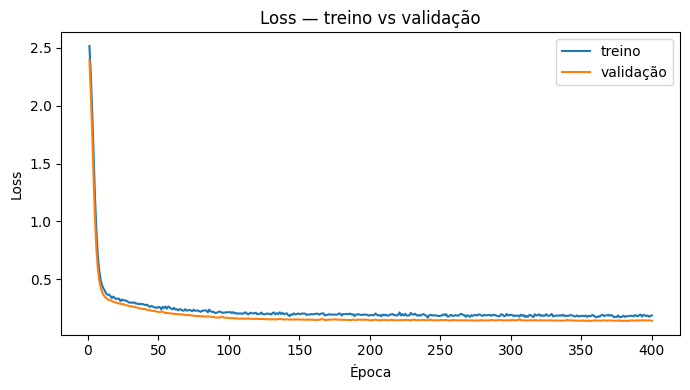

In [32]:

plt.figure(figsize=(7,4))
plt.plot(range(1,len(train_losses)+1), train_losses, label="treino")
plt.plot(range(1,len(val_losses)+1),   val_losses,   label="validação")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Loss — treino vs validação")
plt.legend(); plt.tight_layout(); plt.show()


## 6) Acurácia

In [33]:

def eval_acc(model, loader):
    model.eval(); cor, tot = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb.to(device))
            pred = logits.argmax(1).cpu()
            cor += (pred == yb).sum().item()
            tot += yb.size(0)
    return cor/tot

acc_tr = eval_acc(model, train_loader)
acc_te = eval_acc(model, test_loader)
print(f"Acurácia treino: {acc_tr:.3f} | teste: {acc_te:.3f}")
# Acurácia treino: 0.929 | teste: 0.953


Acurácia treino: 0.926 | teste: 0.950


## 7) Fronteira de decisão

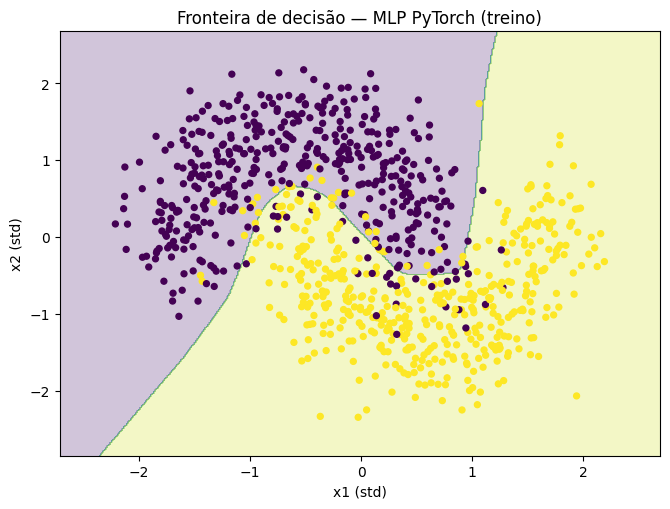

In [34]:

xmin, xmax = X_train_s[:,0].min()-0.5, X_train_s[:,0].max()+0.5
ymin, ymax = X_train_s[:,1].min()-0.5, X_train_s[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 400), np.linspace(ymin, ymax, 400))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

with torch.no_grad():
    Z = model(torch.tensor(grid, device=device)).argmax(1).view(xx.shape).cpu().numpy()

plt.figure(figsize=(6.8,5.2))
plt.contourf(xx, yy, Z, alpha=0.25)
plt.scatter(X_train_s[:,0], X_train_s[:,1], c=y_train, s=18)
plt.title("Fronteira de decisão — MLP PyTorch (treino)")
plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
plt.tight_layout(); plt.show()


## 8) Sugestões de variação

In [35]:

print("Experimente: hidden=(64,32), dropout=0.2, lr=5e-4, weight_decay=1e-3, epochs=400.")

Experimente: hidden=(64,32), dropout=0.2, lr=5e-4, weight_decay=1e-3, epochs=400.
